In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize,normalize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
from functools import reduce
from scipy.io import loadmat
from skimage.measure import block_reduce
from collections import Counter
from scipy.sparse import coo_matrix,hstack, vstack
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(0)
print (torch.cuda.current_device())

0


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/origa650/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        trN.append(iname)
        if itype==True: #glaucoma
            trY.append(1)
        else: trY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        teN.append(iname)
        if itype==True: #glaucoma
            teY.append(1)
        else: teY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

585 / 585 The length of trainset is 585
65 / 65 The length of testset is 65
Completed data handle in 96 seconds


In [3]:
class L2Normalization(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(L2Normalization, self).__init__()
        self.eps = 1e-8
        
    def forward(self, x):
        if x.is_cuda:
            caped_eps = Variable(torch.Tensor([self.eps])).cuda(torch.cuda.device_of(x).idx)
        else:
            caped_eps = Variable(torch.Tensor([self.eps]))
        x = torch.div(x.transpose(0,1),x.max(1)[0]).transpose(0,1) # max_normed
        norm = torch.norm(x,2,1) + caped_eps.expand(x.size()[0])
        y = torch.div(x.transpose(0,1),norm).transpose(0,1)
        return y
    
class RMAC(nn.Module):
    """
    Regional Maximum activation of convolutions (R-MAC).
    c.f. https://arxiv.org/pdf/1511.05879.pdf
    Args:
        level_n (int): number of levels for selecting regions.
    """
    def __init__(self,level_n:int):
        super(RMAC, self).__init__()
        self.first_show = True
        self.cached_regions = dict()
        self.level_n = level_n

    def _get_regions(self, h: int, w: int) -> List:
        """
        Divide the image into several regions.
        Args:
            h (int): height for dividing regions.
            w (int): width for dividing regions.
        Returns:
            regions (List): a list of region positions.
        """
        if (h, w) in self.cached_regions:
            return self.cached_regions[(h, w)]

        m = 1
        n_h, n_w = 1, 1
        regions = list()
        if h != w:
            min_edge = min(h, w)
            left_space = max(h, w) - min(h, w)
            iou_target = 0.4
            iou_best = 1.0
            while True:
                iou_tmp = (min_edge ** 2 - min_edge * (left_space // m)) / (min_edge ** 2)

                # small m maybe result in non-overlap
                if iou_tmp <= 0:
                    m += 1
                    continue

                if abs(iou_tmp - iou_target) <= iou_best:
                    iou_best = abs(iou_tmp - iou_target)
                    m += 1
                else:
                    break
            if h < w:
                n_w = m
            else:
                n_h = m

        for i in range(self.level_n):
            region_width = int(2 * 1.0 / (i + 2) * min(h, w))
            step_size_h = (h - region_width) // n_h
            step_size_w = (w - region_width) // n_w

            for x in range(n_h):
                for y in range(n_w):
                    st_x = step_size_h * x
                    ed_x = st_x + region_width - 1
                    assert ed_x < h
                    st_y = step_size_w * y
                    ed_y = st_y + region_width - 1
                    assert ed_y < w
                    regions.append((st_x, st_y, ed_x, ed_y))

            n_h += 1
            n_w += 1

        self.cached_regions[(h, w)] = regions
        return regions

    def forward(self, fea:torch.tensor) -> torch.tensor:
        final_fea = None
        if fea.ndimension() == 4:
            h, w = fea.shape[2:]       
            regions = self._get_regions(h, w)
            for _, r in enumerate(regions):
                st_x, st_y, ed_x, ed_y = r
                region_fea = (fea[:, :, st_x: ed_x, st_y: ed_y].max(dim=3)[0]).max(dim=2)[0]#max-pooling
                region_fea = region_fea / torch.norm(region_fea, dim=1, keepdim=True)#PCA-whitening
                if final_fea is None:
                    final_fea = region_fea
                else:
                    final_fea = final_fea + region_fea
        else:# In case of fc feature.
            assert fea.ndimension() == 2
            if self.first_show:
                print("[RMAC Aggregator]: find 2-dimension feature map, skip aggregation")
                self.first_show = False
            final_fea = fea
        return final_fea

In [4]:
#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class NNet(nn.Module):
    def __init__(self, block, num_blocks=[2,2,2,2], n_classes=2, code_size=64):
        super(NNet, self).__init__()
        # Bottom-up layers，classifcation loss
        self.in_planes = 8  #3 D->64 channels
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        self.layer2 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer3 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer4 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer5 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(256, 32, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(32*4*4, code_size)#code_size:length of hash code
        self.fc2 = nn.Linear(code_size, n_classes) #num_classes:number of classes
        
        # Top-down layer, segmentation loss
        self.toplayer = nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0)  # Reduce channels
        
        self.latlayer1 = nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0)# Lateral layers
        self.latlayer2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        
        self.upsample = nn.Upsample((256,256), mode='bilinear',align_corners=True)
        self.conv7 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)#mask 0,1,2
        
        # Hash layer, ranking loss
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.r_mac_pool = RMAC(level_n=3) 
        self.l2norm = L2Normalization()
        self.fc3 = nn.Linear(512, n_classes) #num_classes:number of classes

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up, classifcation loss
        h1 = F.relu(self.bn1(self.conv1(x)))#(3,256,256)->(8,128,128)
        h1 = F.max_pool2d(h1, kernel_size=3, stride=2, padding=1)#(8,128,128)->(8,64,64)
        
        h2 = self.layer2(h1)#(8,64,64)->(32,64,64)
        h3 = self.layer3(h2)#(32,64,64)->(64,32,32)
        h4 = self.layer4(h3)#(64,32,32)->(128,16,16)
        h5 = self.layer5(h4)#(128,16,16)->(256,8,8)
        
        h6 = self.conv6(h5)#(256,8,8)->(32,4,4) 
        h6 = h6.view(h6.size(0), -1)#conv->linear
        h_feat = self.fc1(h6)
        h_cls = self.fc2(h_feat)
        
        # Top-down, segmentation loss
        s5 = self.toplayer(h5)#(256,8,8)->(32,8,8)
        s4 = self._upsample_add(s5, self.latlayer1(h4))#{(32,8,8),(32, 16, 16)}->(32, 16, 16)
        s3 = self._upsample_add(s4, self.latlayer2(h3))#{(32, 16, 16),(32, 32, 32)}->(32, 32, 32)
        s2 = self._upsample_add(s3, h2) #{(32, 32, 32),(32, 64, 64)}->(32, 64, 64)
        
        s1 = self.upsample(s2)#(32, 64, 64)->(32, 256, 256)
        s_mask = self.bn2(self.conv7(s1))#(32, 256, 256)->(3, 256, 256)
        
        #Hash, ranking loss
        c5 = self.conv8(h5)#(256,8,8)->(512,8,8)
        
        c4 = self.r_mac_pool(c5) 
        
        c_feat = self.l2norm(c4) #512
        c_cls = self.fc3(c_feat)

        return h_feat, h_cls, s_mask, c_feat, c_cls

In [5]:
net = NNet(block=Bottleneck)
fms = net(Variable(torch.randn(10,3,256,256)))
for fm in fms:
    print(fm.size())

/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/root/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 64])
torch.Size([10, 2])
torch.Size([10, 3, 256, 256])
torch.Size([10, 512])
torch.Size([10, 2])


In [39]:
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    trQ_m, trP_m, trN_m = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        trQ_m.append(trM[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            trP_m.append(trM[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
            trN_m.append(trM[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y), np.array(trQ_m), np.array(trP_m), np.array(trN_m)
#sample  triplet labels
trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y, trQ_m, trP_m, trN_m = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (trQ_m.shape==trP_m.shape and trQ_m.shape==trN_m.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = NNet(block=Bottleneck).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes #F.log_softmax+F.nll_loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_q_m = trQ_m[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_p_m = trP_m[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    train_n_m = trN_m[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        Q_m_batch = torch.from_numpy(train_q_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_m_batch = torch.from_numpy(train_p_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_m_batch = torch.from_numpy(train_n_m[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_h_feat, Q_h_cls, Q_s_mask, Q_c_feat, Q_c_cls = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_h_feat, P_h_cls, P_s_mask, P_c_feat, P_c_cls = model(P_batch.permute(0, 3, 1, 2))
        N_h_feat, N_h_cls, N_s_mask, N_c_feat, N_c_cls = model(N_batch.permute(0, 3, 1, 2))
        #loss
        #rank_loss = tl_loss(Q_h_feat,P_h_feat,N_h_feat)
        #rank_loss.backward(retain_graph=True)
        cls_loss = ce_loss(Q_c_cls, Q_y_batch) + ce_loss(P_c_cls, P_y_batch) + ce_loss(N_c_cls, N_y_batch) 
        cls_loss.backward(retain_graph=True)
        mask_loss = ce_loss(Q_s_mask, Q_m_batch) + ce_loss(P_s_mask, P_m_batch) + ce_loss(N_s_mask, N_m_batch)
        mask_loss.backward()
        optimizer.step()#update parameters
        #show loss
        loss = mask_loss + cls_loss 
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
torch.cuda.empty_cache()

#hash code of train data 
batchSize = 10
num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, _, _, _ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(x_hash.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data
teF = []
teM_pred = []
teY_pred = []
num_batches = len(teY) // batchSize  +1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, _, x_mask, _, x_cls = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_mask = F.log_softmax(x_mask,dim=1) 
    m_pred = x_mask.max(1,keepdim=True)[1]
    teM_pred.extend(m_pred.cpu().data.numpy().tolist())
    x_cls = F.log_softmax(x_cls,dim=1) 
    y_pred = x_cls.max(1,keepdim=True)[1]
    teY_pred.extend(y_pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#retrieval performance
for topk in [5,10,20,50]:
    mAP = [] #mean average precision
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
    print("mAP@{}={:.4f}".format(topk, np.mean(mAP)))
#segementation performance  
mIoU=[]
for i in range(len(teM)):
    a = teM[i]
    b = np.array(teM_pred[i][0])
    #iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    #iou_score = np.where(a.flatten()==b.flatten(),1,0)
    iou_score = a == b
    mIoU.append(np.mean(iou_score))
print("mIoU={:.4f}".format(np.mean(mIoU)))
#classification performance
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))

 59 / 59 : loss = 4.719812Eopch:     1 mean_loss = 5.134569
 59 / 59 : loss = 4.856025Eopch:     2 mean_loss = 4.727883
 59 / 59 : loss = 4.285197Eopch:     3 mean_loss = 4.335294
 59 / 59 : loss = 3.866675Eopch:     4 mean_loss = 4.047650
 59 / 59 : loss = 4.188878Eopch:     5 mean_loss = 3.672754
 59 / 59 : loss = 2.558735Eopch:     6 mean_loss = 3.178646
 59 / 59 : loss = 2.406787Eopch:     7 mean_loss = 2.974782
 59 / 59 : loss = 2.582802Eopch:     8 mean_loss = 2.570779
 59 / 59 : loss = 1.832361Eopch:     9 mean_loss = 2.391907
 59 / 59 : loss = 1.666135Eopch:    10 mean_loss = 2.046804
best_loss = 2.046804
 6 / 7 9 Completed buliding index in 1 seconds
mAP@5=0.7316
mAP@10=0.6902
mAP@20=0.6648
mAP@50=0.6200
mIoU=0.9813
Accuracy: 0.723077


In [38]:
#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
Q_batch = Q_batch.cpu()
Q_y_batch = Q_y_batch.cpu()
Q_m_batch = Q_m_batch.cpu()
P_batch = P_batch.cpu()
P_y_batch = P_y_batch.cpu()
P_m_batch = P_m_batch.cpu()
N_batch = N_batch.cpu()
N_y_batch = N_y_batch.cpu()
N_m_batch = N_m_batch.cpu()
torch.cuda.empty_cache()

In [88]:
print(trY[5])
print(trN[5])

1
556


(-0.5, 3071.5, 2047.5, -0.5)

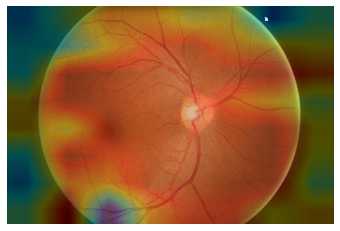

In [92]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

#original
image_path='/data/fjsdata/MCBIR-Ins/origa650/images/190.jpg' 
oriImg = mpimg.imread(image_path)
#oriImg = cv2.resize(mpimg.imread(image_path), (256, 256))
#cv2.IMREAD_GRAYSCALE,mpimg.imread(image_path),cv2.imread(image_path)
#oriImg = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/343.mat')['mask']
#oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)
#print(Counter(oriImg.flatten()))
#plt.imshow(oriImg)
#plt.axis('off')

#train
data = torch.from_numpy(np.array(trI[0:1])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.layer5.register_forward_hook(get_activation('layer5'))#maxpool
feature = activation['layer5'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width = oriImg.shape[0],oriImg.shape[1]
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
added_image = cv2.addWeighted(oriImg,0.7,featuremap,0.3,0)
plt.imshow(added_image)
plt.axis('off')

(-0.5, 3071.5, 2047.5, -0.5)

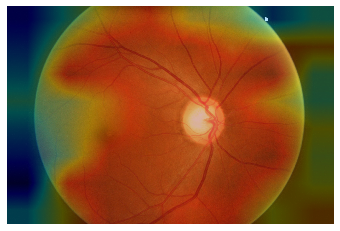

In [94]:
#original
image_path='/data/fjsdata/MCBIR-Ins/origa650/images/556.jpg' 
oriImg = mpimg.imread(image_path)
#oriImg = cv2.resize(mpimg.imread(image_path), (256, 256))

#train
data = torch.from_numpy(np.array(trI[5:6])).type(torch.FloatTensor).cuda()
output = best_net(data.permute(0, 3, 1, 2))#forword
#conv1         
best_net.layer5.register_forward_hook(get_activation('layer5'))#maxpool
feature = activation['layer5'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width = oriImg.shape[0],oriImg.shape[1]
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
added_image = cv2.addWeighted(oriImg,0.7,featuremap,0.3,0)
plt.imshow(added_image)
plt.axis('off')

In [81]:
scores, neighbors = gpu_index.search(np.array(teF[2:3]).astype('float32'), k=10)
print(teN[2]+'<->'+str(teY[2]))
for j in neighbors[0].tolist():
    print(trN[j]+'<->'+str(trY[j]))

612<->1
464<->0
233<->1
231<->0
304<->1
218<->0
643<->0
597<->0
615<->1
433<->1
060<->0


(2048, 3072)
(2048, 3072)


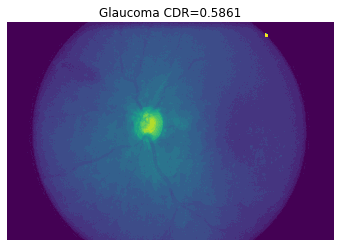

In [26]:
background = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/612.jpg',0)#grayscale  mode
print(background.shape)
overlay = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/612.mat')['mask']
print(overlay.shape)
added_image = cv2.addWeighted(background,0.5,overlay,1.0,0)
plt.axis('off')
plt.title('Glaucoma CDR=0.5861' )
plt.imshow(added_image)
plt.show()

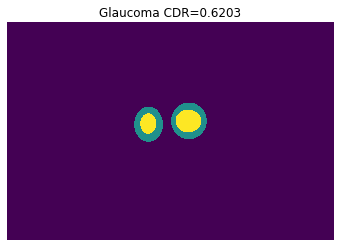

In [41]:
#background = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/618.jpg',0)#grayscale  mode
background = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/612.mat')['mask']
overlay = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/618.mat')['mask']
added_image = cv2.addWeighted(background,1.0,overlay,1.0,0)
plt.axis('off')
plt.title('Glaucoma CDR=0.6203' )
plt.imshow(added_image)
plt.show()

Counter({0: 64767, 1: 553, 2: 216})
769
64767


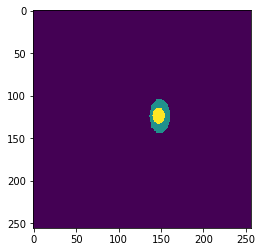

In [43]:
from collections import Counter
print(Counter(np.array(trM[0]).flatten()))
pred_inds = trM[0]!= 0
pred_sum = pred_inds.sum()
print (pred_sum)
pred_inds = trM[0]== 0
pred_sum = pred_inds.sum()
print (pred_sum)
imgplot = plt.imshow(trM[0])
plt.show()

(2048, 3072)
Counter({0: 6167909, 2: 113069, 1: 10478})


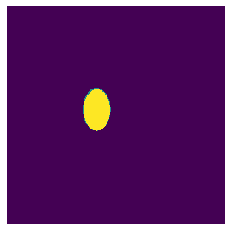

In [5]:
from collections import Counter
mask = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/003.mat')['mask']
print (mask.shape)
print(Counter(mask.flatten()))
mask =  cv2.resize(mask,(256,256))
imgplot = plt.imshow(mask)
plt.axis('off')
plt.show()

<class 'numpy.ndarray'>
(2048, 3072)


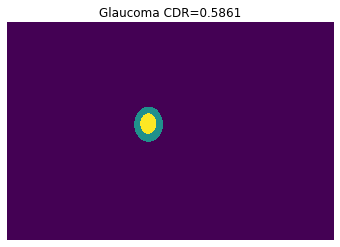

In [43]:
#img=mpimg.imread('/data/fjsdata/MCBIR-Ins/origa650/images/612.jpg')
#img = img.mean(axis=2)
#img = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/649.jpg')
img = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/612.mat')['mask']
print(type(img))
print (img.shape)
plt.title('Glaucoma CDR=0.5861' )
plt.axis('off')
imgplot = plt.imshow(img)
plt.show()

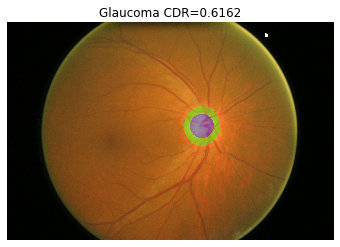

In [24]:
import PIL.ImageOps   
#img=mpimg.imread('/data/fjsdata/MCBIR-Ins/origa650/images/612.jpg')
#img = img.mean(axis=2)
#img = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/649.jpg')
#ori_img = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/618.jpg',0)#grayscale  mode
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img
           
ori_img = Image.open('/data/fjsdata/MCBIR-Ins/origa650/images/246.jpg').convert('RGBA') #gray mode

mask_img = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/246.mat')['mask']
mask_img = normalize_output(mask_img)*255
mask_img = Image.fromarray(mask_img).convert('RGB')#PIL.Image
mask_img = PIL.ImageOps.invert(mask_img).convert('RGBA')
#transparency
datas = mask_img.getdata()
newData = list()
for item in datas:
    if item[0] ==255 and item[1] ==255 and item[2] ==255: #white
        newData.append(( 255, 255, 255, 0))#Transparency
    elif item[0] ==0 and item[1] ==0 and item[2] ==0: #black
        newData.append(( 0, 0, 255, 100))    #opaque  to blue
    else:#gray
        #newData.append(( item[0],item[1],item[2], 100))
        newData.append(( 0 , 255, 0, 100)) #green
mask_img.putdata(newData)

#overlay = Image.blend(ori_img, mask_img, alpha=0.5)
overlay = Image.alpha_composite(ori_img, mask_img)
#ori_img.paste(mask_img, (0, 0), mask_img)
plt.title('Glaucoma CDR=0.6162' )
plt.axis('off')
imgplot = plt.imshow(overlay)#cmap='gray'
plt.show()

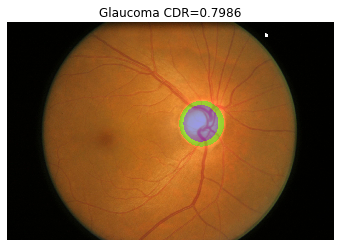

In [23]:
import PIL.ImageOps   
#img=mpimg.imread('/data/fjsdata/MCBIR-Ins/origa650/images/612.jpg')
#img = img.mean(axis=2)
#img = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/649.jpg')
#ori_img = cv2.imread('/data/fjsdata/MCBIR-Ins/origa650/images/618.jpg',0)#grayscale  mode
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img
           
ori_img = Image.open('/data/fjsdata/MCBIR-Ins/origa650/images/069.jpg').convert('RGBA') #gray mode

mask_img = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/069.mat')['mask']
mask_img = normalize_output(mask_img)*255
mask_img = Image.fromarray(mask_img).convert('RGB')#PIL.Image
mask_img = PIL.ImageOps.invert(mask_img).convert('RGBA')
#transparency
datas = mask_img.getdata()
newData = list()
for item in datas:
    if item[0] ==255 and item[1] ==255 and item[2] ==255: #white
        newData.append(( 255, 255, 255, 0))#Transparency
    elif item[0] ==0 and item[1] ==0 and item[2] ==0: #black
        newData.append(( 0, 0, 255, 100))    #opaque  to blue
    else:#gray
        #newData.append(( item[0],item[1],item[2], 100))
        newData.append(( 0 , 255, 0, 100)) #green
mask_img.putdata(newData)

#overlay = Image.blend(ori_img, mask_img, alpha=0.5)
overlay = Image.alpha_composite(ori_img, mask_img)
#ori_img.paste(mask_img, (0, 0), mask_img)
plt.title('Glaucoma CDR=0.7986' )
plt.axis('off')
imgplot = plt.imshow(overlay)#cmap='gray'
plt.show()